In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

In [2]:
import matplotlib.pyplot as plt
import time

In [3]:
from style_decorator import StyleDecorator
from PIL import Image

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
torch.cuda.is_available()

True

In [6]:
path = './avatar.pth'
pretrained = torch.load(path)

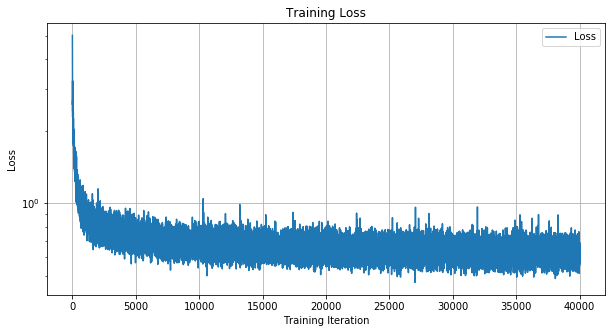

In [7]:
loss = pretrained['loss_seq']
plt.figure(figsize=(10, 5))
plt.semilogy(loss['total'], label="Loss")
plt.xlabel("Training Iteration"); plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.title("Training Loss")
plt.show()    

In [8]:
class AvatarNet(nn.Module):
    def __init__(self, layers=[1, 6, 11, 20]):
        super(AvatarNet, self).__init__()
        self.encoder = Encoder(layers)
        self.decoder = Decoder(layers)
        self.adain = AdaIN()
        self.decorator = StyleDecorator()

    def forward(self, content, styles, style_strength=1.0, patch_size=3, patch_stride=1, interpolation_weights=None):
        if interpolation_weights is None:
            interpolation_weights = [1/len(styles)] * len(styles)
        content_feature = self.encoder(content)
        style_features = []
        for style in styles:
            style_features.append(self.encoder(style))
        transformed_feature = []
        for style_feature, interpolation_weight in zip(style_features, interpolation_weights):
            transformed_feature.append(self.decorator(content_feature[-1], style_feature[-1], style_strength, patch_size, patch_stride) * interpolation_weight)
        transformed_feature = sum(transformed_feature)
        style_features = [style_feature[:-1][::-1] for style_feature in style_features]
        stylized_image = self.decoder(transformed_feature, style_features, interpolation_weights)
        return stylized_image

class AdaIN(nn.Module):
    def __init__(self):
        super(AdaIN, self).__init__()
    
    def forward(self, content, style, style_strength=1.0, eps=1e-5):
        b, c, h, w = content.size()
        content_std, content_mean = torch.std_mean(content.view(b, c, -1), dim=2, keepdim=True)
        style_std, style_mean = torch.std_mean(style.view(b, c, -1), dim=2, keepdim=True)
        normalized_content = (content.view(b, c, -1) - content_mean)/(content_std+eps)
        stylized_content = (normalized_content * style_std) + style_mean
        output = (1-style_strength)*content + style_strength*stylized_content.view(b, c, h, w)
        return output
    
class Encoder(nn.Module):
    def __init__(self,  layers=[1, 6, 11, 20]):        
        super(Encoder, self).__init__()
        vgg = torchvision.models.vgg19(pretrained=True).features
        self.encoder = nn.ModuleList()
        temp_seq = nn.Sequential()
        for i in range(max(layers)+1):
            temp_seq.add_module(str(i), vgg[i])
            if i in layers:
                self.encoder.append(temp_seq)
                temp_seq = nn.Sequential()
        
    def forward(self, x):
        features = []
        for layer in self.encoder:
            x = layer(x)
            features.append(x)
        return features


class Decoder(nn.Module):
    def __init__(self, layers=[1, 6, 11, 20], transformers=[AdaIN(), AdaIN(), AdaIN(), None]):
        super(Decoder, self).__init__()
        vgg = torchvision.models.vgg19(pretrained=False).features
        self.transformers = transformers
        self.decoder = nn.ModuleList()
        temp_seq  = nn.Sequential()
        count = 0
        for i in range(max(layers)-1, -1, -1):
            if isinstance(vgg[i], nn.Conv2d):
                out_channels = vgg[i].in_channels
                in_channels = vgg[i].out_channels
                kernel_size = vgg[i].kernel_size
                temp_seq.add_module(str(count), nn.ReflectionPad2d(padding=(1,1,1,1)))
                count += 1
                temp_seq.add_module(str(count), nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size))
                count += 1
                temp_seq.add_module(str(count), nn.ReLU())
                count += 1
            elif isinstance(vgg[i], nn.MaxPool2d):
                temp_seq.add_module(str(count), nn.Upsample(scale_factor=2))
                count += 1
            if i in layers:
                self.decoder.append(temp_seq)
                temp_seq  = nn.Sequential()
        self.decoder.append(temp_seq[:-1])    
        
    def forward(self, x, styles, interpolation_weights=None):
        if interpolation_weights is None:
            interpolation_weights = [1/len(styles)] * len(styles)
        y = x
        for i, layer in enumerate(self.decoder):
            y = layer(y)
            if self.transformers[i]:
                transformed_feature = []
                for style, interpolation_weight in zip(styles, interpolation_weights):
                    transformed_feature.append(self.transformers[i](y, style[i]) * interpolation_weight)
                y = sum(transformed_feature)
        return y

In [9]:
network = AvatarNet().to(device)
network.load_state_dict(pretrained['state_dict'])

<All keys matched successfully>

In [10]:
def _normalizer(denormalize=False):
    MEAN = [0.485, 0.456, 0.406]
    STD = [0.229, 0.224, 0.225]    
    if denormalize:
        MEAN = [-mean/std for mean, std in zip(MEAN, STD)]
        STD = [1/std for std in STD]
    return transforms.Normalize(mean=MEAN, std=STD)

def _transformer(imsize=None, cropsize=None, cencrop=False):
    normalize = _normalizer()
    transformer = []
    if imsize:
        transformer.append(transforms.Resize(imsize))
    if cropsize:
        if cencrop:
            transformer.append(transforms.CenterCrop(cropsize))
        else:
            transformer.append(transforms.RandomCrop(cropsize))
    transformer.append(transforms.ToTensor())
    transformer.append(normalize)
    return transforms.Compose(transformer)

In [11]:
def imshow(tensor):
    denormalize = _normalizer(denormalize=True)    
    if tensor.is_cuda:
        tensor = tensor.cpu()    
    tensor = torchvision.utils.make_grid(denormalize(tensor.squeeze(0)))
    image = transforms.functional.to_pil_image(tensor.clamp_(0.0, 1.0))
    return image

In [12]:
def imload(path, imsize=None, cropsize=None, cencrop=False):
    transformer = _transformer(imsize, cropsize, cencrop)
    return transformer(Image.open(path).convert("RGB")).unsqueeze(0)

In [13]:
# change image here
content_path = 'image/000005.jpg'
style_path = 'style/the_scream.jpg'
imsize, cropsize, cencrop = 178, 178, True
content_img = imload(content_path, imsize, cropsize, cencrop).to(device)
style_img = imload(style_path, imsize, cropsize, cencrop).to(device)

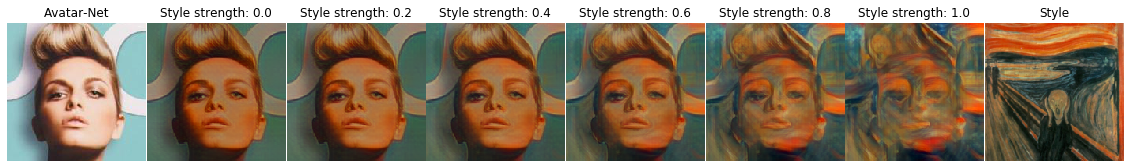

In [14]:
import time
start = time.time()
plt.figure(figsize=(20, 5)); plt.subplots_adjust(wspace=0.01)
for count, style_strength in enumerate([a/10 for a in range(0,11,2)], 2):
    with torch.no_grad():
        stylized_img = network(content_img, [style_img], style_strength=style_strength)
        plt.subplot(1, 8, count); plt.imshow(imshow(stylized_img)); plt.title("Style strength: %1.1f"%style_strength); plt.axis('off')
plt.subplot(1, 8, 1); plt.imshow(imshow(content_img)); plt.title("Avatar-Net"); plt.axis('off')
plt.subplot(1, 8, 8); plt.imshow(imshow(style_img)); plt.title("Style"); plt.axis('off')
plt.savefig('content_style_interpolation.jpg', bbox_inches='tight', quality=100, dpi=350)
plt.show()

In [15]:
content_path = 'image/000006.jpg'
style_paths = ['style/mondrian.jpg', 'style/yellow_sunset.jpg']
imsize, cropsize, cencrop = 178, 178, True
content_img = imload(content_path, imsize, cropsize, cencrop).to(device)
style_imgs = [imload(style_path, imsize, cropsize, cencrop).to(device) for style_path in style_paths]

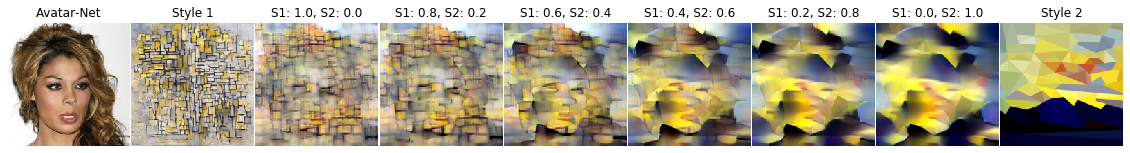

In [16]:
plt.figure(figsize=(20, 5)); plt.subplots_adjust(wspace=0.01)
for count, alpha in enumerate([a/10 for a in range(0,11,2)], 3):
    with torch.no_grad():
        stylized_img = network(content_img, style_imgs, style_strength=1.0, interpolation_weights=[1-alpha, alpha])
        plt.subplot(1, 9, count); plt.imshow(imshow(stylized_img)); plt.title("S1: %1.1f, S2: %1.1f"%(1-alpha, alpha)); plt.axis('off')
plt.subplot(1, 9, 1); plt.imshow(imshow(content_img)); plt.title("Avatar-Net"); plt.axis('off')
plt.subplot(1, 9, 2); plt.imshow(imshow(style_imgs[0])); plt.title("Style 1"); plt.axis('off')
plt.subplot(1, 9, 9); plt.imshow(imshow(style_imgs[1])); plt.title("Style 2"); plt.axis('off')
plt.savefig('multiple_style_interpolation.jpg', bbox_inches='tight', quality=100, dpi=350)
plt.show()